# 한눈에 보는 머신러닝
##### 모든 데이터 과학자가 꼭 알아야할 여러 가지 기초 개념과 용어 설명

## 주요 내용

1. 모델 기반 학습
    - 선형 회귀
1. 머신러닝의 주요 도전 과제
    - 대표성 없는 훈련 데이터
    - 과대적합과 모델 규제
1. 사례 기반 학습
    - k-최근접 이웃 회귀

__참고:__ 
핵심 설명과 코드는 &#x1f511;로 표시되었으며 굳이 알아둘 필요가 없는 코드는 &#x270b;로 표시되었다.

## 기본 설정

파이썬 3을 이용한다.

* 파이썬 버전: 3.5 이상
* scikit-learn 버전: 0.20 이상

In [1]:
# 파이썬 버전 ≥ 3.5
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn 버전 ≥0.20
import sklearn
assert sklearn.__version__ >= "0.20"

다음은 주피터 노트북에서 그래프를 깔금하게 그리기 위한 설정이다.

In [2]:
%matplotlib inline 

import matplotlib as mpl
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

필요한 모듈은 다음과 같다.

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

## 모델 기반 학습

선형회귀 모델을 학습시키는 과정을 통해 다섯 단계로 이루어진 머신러닝 문제해결의 전형적인 과정을 살펴본다.

1. 문제 정의
1. 데이터 구하기
1. 데이터 적재, 정제, 전처리
1. 모델 선택과 훈련
1. 학습된 모델 활용

### &#x270b; 그래프 저장 함수 선언

아래 `save_fig()` 함수는 지정된 디렉토리에 생성된 도표를 저장하는 함수이다.
저자 본인이 책에 사용될 도표를 저장해 두기 위해 정의한 것으로 보인다.
코드 이해를 위해 전혀 필요없는 부분이지만, 이런 용도의 함수를 정의할 수 있다는 정도는 기억해 두어야 한다.

In [4]:
import os

# 그래프 저장을 디렉토리 지정
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "fundamentals"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

# 그래프 저장 함수 선언
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

#### 무작위성 시드 지정

실행할 때 마다 동일한 결과가 나오도록 무작위 함수들의 시드(seed)를 지정한다.

__참고:__ 실습용 데이터에 무작위로 생성된 데이터를 더해 훈련 효과를 높이는 경우가 많다. 따라서 동일한 코드를 반복 실행할 때 동일한 결과를 생성하도록 무작위성의 시드를 지정한다. 사용되는 시드번호는 중요하지 않다.

In [5]:
import numpy as np

np.random.seed(42)

### 1단계: 문제 정의

어느 국가의 1인당 GDP가 알려졌을 때 해당 국가의 삶의 만족도를 예측하는 모델(함수)을 구현한다.

### 2단계: 데이터 구하기

1인당 GDP와 삶의 만족도 사이의 관계를 예측하는 모델을 구현하기위해 소위 __모델 훈련__ 과정을 실행해야 한다.
모델 훈련을 위해 필요한 데이터셋(데이터 집합)을 __훈련 세트__라 부르며,
훈련 세트는 __입력__ 데이터와 __타깃__(target) 데이터로 구분된다.
그러면 모델 훈련은 준비된 훈련 세트의 입력 데이터와 타깃 데이터 사이의 관계를 가장 적절하게 
묘사하는 특정 모델(함수)을 학습해가는 과정이다.

1인당 GDP와 삶의 만족도 사이의 관계를 가장 적절하게 묘사하는 모델(함수)를 훈련시키기 위해
사용되는 훈련 세트는 여기서는 다음과 같다.

- 국가별 1인당 [GDP](https://ko.wikipedia.org/wiki/%EA%B5%AD%EB%82%B4%EC%B4%9D%EC%83%9D%EC%82%B0)
    데이터: [국제통화기금(IMF)](https://ko.wikipedia.org/wiki/%EA%B5%AD%EC%A0%9C_%ED%86%B5%ED%99%94_%EA%B8%B0%EA%B8%88#:~:text=%EA%B5%AD%EC%A0%9C%20%ED%86%B5%ED%99%94%20%EA%B8%B0%EA%B8%88(%E5%9C%8B%E9%9A%9B%E9%80%9A%E8%B2%A8,%EC%9C%84%EC%9E%84%EB%B0%9B%EC%9D%80%20%EA%B5%AD%EC%A0%9C%20%EA%B8%B0%EA%B5%AC%EC%9D%B4%EB%8B%A4.)의 
[세계 경제전망 데이터베이스](http://goo.gl/j1MSKe)에 포함됨.
- [OECD](https://ko.wikipedia.org/wiki/%EA%B2%BD%EC%A0%9C%ED%98%91%EB%A0%A5%EA%B0%9C%EB%B0%9C%EA%B8%B0%EA%B5%AC)
    회원 국가별 '삶의 만족도'(life satisfaction) 데이터: OECD가 매년 발표하는 
    ['더 나은 삶의 지수'(BLI, Better Life Index) 자료](https://stats.oecd.org/Index.aspx?DataSetCode=BLI)에 포함되어 있음.

여기서는 2015년 기준 자료를 아래 링크에서 미리 준비된 두 개의 데이터 파일을 다운로드하는 것으로 대체한다.
다만 실제 자료를 아래와 같이 잘 정리된 데이터 파일로 만드는 과정이 일반적으로 간단하지 않다는 점만을 언급해둔다.

* `oecd_bli_2015.csv`: 2015년도 기준 OECD 국가들의 '더 나은 삶의 지수'(BLI) 데이터
* `gdp_per_capita.csv`: IMF(국제통화기금)에 제공하는 1인당 국내총생산 데이터(GDP) 데이터

다운로드 경로는 다음과 같다.

In [6]:
datapath = "https://raw.githubusercontent.com/codingalzi/handson-ml2/master/notebooks/datasets/lifesat/"

위 경로에 파일의 이름을 추가하면 해당 파일을 다운로드하여 컴퓨터에 저장할 수 있다.
하지만 컴퓨터에 저장하는 대신 이어서 설명하는 데이터 적재를 동시에 진행하는 것으로 
데이터 구하기 단계를 해결한다.

### 3단계: 데이터 적재, 정제, 전처리

컴퓨터에 저장된 또는 다운로드된 데이터는 일반적으로 바로 모델 훈련에 사용할 수 없으며, 
데이터 적재, 데이터 정제, 데이터 전처리 등의 과정을 거쳐야 비로소 모델 훈련에 활용될 수 있다.

* __데이터 적재__(data loading): 인터넷에 존재하거나 컴퓨터에 저장되어 있는 파일을 
    특정 자료형의 값으로 불러오는 과정

* __데이터 정제__(data cleaning): 적재된 데이터셋에 포함된 오류, 부정확한 값, 
    누락된 값, 상관없는 값 등을 제거, 수정, 보완하는 과정

* __데이터 전처리__(data preprocessing): 정제된 데이터셋에서 출발하여
    적절한 내용의 데이터를 추가한 후 적절한 형식으로 변환하는 과정

#### 1인당 GDP 데이터 적재, 정제, 전처리

아래 코드는 IMF 에서 다운로드한 csv 파일에서 2015년 기준 국가별 1인당 GDP 관련 데이터를 데이터프레임 객체로 불러온다.

- `thousands=','`: 1000단위로 쉼표 찍기
- `delimiter='\t'`: 탭(tab)으로 열 구분
- `encoding='latin1'`: 인코딩 방식 지정. 파일에서 사용된 'C&ocirc;te d'Ivoire'(코트디브와르)와 같은 특수 알파벳을 사용하는 국가명 처리용
- `na_values="n/a"`: 결측치를 'NaN'으로 처리.

In [7]:
gdp_per_capita = pd.read_csv(datapath+"gdp_per_capita.csv", 
                             thousands=',', 
                             delimiter='\t',
                             encoding='latin1', 
                             na_values="n/a")

총 190개 국가의 1인당 GDP 정보를 담고 있다.

In [8]:
gdp_per_capita

,Country,Subject Descriptor,Units,Scale,Country/Series-specific Notes,2015,Estimates Start After
0,Afghanistan,"Gross domestic product per capita, current prices",U.S. dollars,Units,"See notes for: Gross domestic product, curren...",599.994,2013.0
1,Albania,"Gross domestic product per capita, current prices",U.S. dollars,Units,"See notes for: Gross domestic product, curren...",3995.383,2010.0
2,Algeria,"Gross domestic product per capita, current prices",U.S. dollars,Units,"See notes for: Gross domestic product, curren...",4318.135,2014.0
3,Angola,"Gross domestic product per capita, current prices",U.S. dollars,Units,"See notes for: Gross domestic product, curren...",4100.315,2014.0
4,Antigua and Barbuda,"Gross domestic product per capita, current prices",U.S. dollars,Units,"See notes for: Gross domestic product, curren...",14414.302,2011.0
...,...,...,...,...,...,...,...
185,Vietnam,"Gross domestic product per capita, current prices",U.S. dollars,Units,"See notes for: Gross domestic product, curren...",2088.344,2012.0
186,Yemen,"Gross domestic product per capita, current prices",U.S. dollars,Units,"See notes for: Gross domestic product, curren...",1302.940,2008.0
187,Zambia,"Gross domestic product per capita, current prices",U.S. dollars,Units,"See notes for: Gross domestic product, curren...",1350.151,2010.0
188,Zimbabwe,"Gross domestic product per capita, current prices",U.S. dollars,Units,"See notes for: Gross domestic product, curren...",1064.350,2012.0


국가명을 행 인덱스로 지정한다.

In [9]:
gdp_per_capita.set_index("Country", inplace=True)

gdp_per_capita.head()

,Subject Descriptor,Units,Scale,Country/Series-specific Notes,2015,Estimates Start After
Country,,,,,,
Afghanistan,"Gross domestic product per capita, current prices",U.S. dollars,Units,"See notes for: Gross domestic product, curren...",599.994,2013.0
Albania,"Gross domestic product per capita, current prices",U.S. dollars,Units,"See notes for: Gross domestic product, curren...",3995.383,2010.0
Algeria,"Gross domestic product per capita, current prices",U.S. dollars,Units,"See notes for: Gross domestic product, curren...",4318.135,2014.0
Angola,"Gross domestic product per capita, current prices",U.S. dollars,Units,"See notes for: Gross domestic product, curren...",4100.315,2014.0
Antigua and Barbuda,"Gross domestic product per capita, current prices",U.S. dollars,Units,"See notes for: Gross domestic product, curren...",14414.302,2011.0


이어서 1인당 GDP 데이터임을 명시하기 위해 열 이름 `"2015"`를 `"GDP per capita"`로 변경한다.

In [10]:
gdp_per_capita.rename(columns={"2015": "GDP per capita"}, inplace=True) 

gdp_per_capita.head()

,Subject Descriptor,Units,Scale,Country/Series-specific Notes,GDP per capita,Estimates Start After
Country,,,,,,
Afghanistan,"Gross domestic product per capita, current prices",U.S. dollars,Units,"See notes for: Gross domestic product, curren...",599.994,2013.0
Albania,"Gross domestic product per capita, current prices",U.S. dollars,Units,"See notes for: Gross domestic product, curren...",3995.383,2010.0
Algeria,"Gross domestic product per capita, current prices",U.S. dollars,Units,"See notes for: Gross domestic product, curren...",4318.135,2014.0
Angola,"Gross domestic product per capita, current prices",U.S. dollars,Units,"See notes for: Gross domestic product, curren...",4100.315,2014.0
Antigua and Barbuda,"Gross domestic product per capita, current prices",U.S. dollars,Units,"See notes for: Gross domestic product, curren...",14414.302,2011.0


#### 삶의 만족도 데이터 적재, 정제, 전처리

OECD 국가별 삶의 만족도 데이터는 '더 나은 삶의 지수' 데이터 파일에 포함되어 있다. 
따라서 먼저 해당 csv 파일을 판다스의 데이터프레임 객체로 불러온 후에 
삶의 만족도와 관련된 내용을 추출하는 과정을 밟는다.

- `pandas.read_csv()` 함수는 지정한 경로에 저장되어 있는 csv 파일을 다운로드하여 바로 데이터프레임 객체를
생성한다.

In [11]:
oecd_bli = pd.read_csv(datapath + "oecd_bli_2015.csv", thousands=',')

생성된 데이터프레임의 모양은 다음과 같다.

In [12]:
oecd_bli.shape

(3292, 17)

처음 5행를 살펴보자.

In [13]:
oecd_bli.head()

,LOCATION,Country,INDICATOR,Indicator,MEASURE,Measure,INEQUALITY,Inequality,Unit Code,Unit,PowerCode Code,PowerCode,Reference Period Code,Reference Period,Value,Flag Codes,Flags
0,AUS,Australia,HO_BASE,Dwellings without basic facilities,L,Value,TOT,Total,PC,Percentage,0,units,NaN,NaN,1.1,E,Estimated value
1,AUT,Austria,HO_BASE,Dwellings without basic facilities,L,Value,TOT,Total,PC,Percentage,0,units,NaN,NaN,1.0,NaN,NaN
2,BEL,Belgium,HO_BASE,Dwellings without basic facilities,L,Value,TOT,Total,PC,Percentage,0,units,NaN,NaN,2.0,NaN,NaN
3,CAN,Canada,HO_BASE,Dwellings without basic facilities,L,Value,TOT,Total,PC,Percentage,0,units,NaN,NaN,0.2,NaN,NaN
4,CZE,Czech Republic,HO_BASE,Dwellings without basic facilities,L,Value,TOT,Total,PC,Percentage,0,units,NaN,NaN,0.9,NaN,NaN


국가별 삶의 만족도는 `'Life satisfaction'`이라는 측정지표(`'Indicator'`) 열(column)의
특성값 중에 하나이다. 
총 24개 측정지표가 사용되며 그중에 하나임을 확인할 수 있다.

In [14]:
oecd_bli.Indicator.unique()

array(['Dwellings without basic facilities', 'Housing expenditure',
       'Rooms per person', 'Household net adjusted disposable income',
       'Household net financial wealth', 'Employment rate',
       'Job security', 'Long-term unemployment rate', 'Personal earnings',
       'Quality of support network', 'Educational attainment',
       'Student skills', 'Years in education', 'Air pollution',
       'Water quality', 'Consultation on rule-making', 'Voter turnout',
       'Life expectancy', 'Self-reported health', 'Life satisfaction',
       'Assault rate', 'Homicide rate',
       'Employees working very long hours',
       'Time devoted to leisure and personal care'], dtype=object)

In [15]:
oecd_bli.Indicator.unique().shape

(24,)

In [16]:
'Life satisfaction' in oecd_bli.Indicator.unique()

True

그런데 삶의 만족도와 관련된 행이 OECD 회원국의 수인 37보다 많다.
이는 삶의 만족도와 관련해서 데이터의 중복이 있다는 것을 의미한다. 

In [17]:
mask = oecd_bli.Indicator == 'Life satisfaction'
oecd_bli[mask].shape

(179, 17)

무엇이 중복되었는지를 알아내기 위해 
OECD 회원국가별로 `'Indicator'` 열에 포함된 24개 측정지표에 해당하는 값(value)만을 따로 추출해보자.
즉, ['더 나은 삶의 지수'(BLI, Better Life Index) 자료](https://stats.oecd.org/Index.aspx?DataSetCode=BLI)(2021년 5월 18일 자)에서
볼 수 있는 아래 테이블 이미지와 같은 데이터프레임을 생성하고자 한다. 

- 행: OECD 회원국(`Country`)
- 열: 측정지표(`Indicator`)
- 항목 값: 국가별 지표 수치(`Value`)

<div align="center"><img src="https://raw.githubusercontent.com/codingalzi/pydata/master/notebooks/images/oecd_bli.png"/></div>

이를 위해 국가명(`'Country'` 열의 항목)을 행의 인덱스 이름으로, 
`'Indicator'`의 항목을 열의 인덱스 이름으로 사용하는
데이터프레임을 생성한다.
해당 열과 항목에 해당하는 값은 `'Value'` 열에 포함된 값을 사용한다.

이 작업을 위한 전제조건으로 새로운 데이터프레임에 사용될 항목별 값을 유일하게 지정할 수 있어야 한다.
그런데 OECD의 원본 파일에는 각 측정지표의 값으로 국가별 소득 불평등(`'INEQUALITY'`)과 관련된 5가지 
기준에 따라 다섯 개의 값이 포함되어 있다(위 이미지 좌상단 화살표 참조).

| 기준   | 기호 | 대상     |
| :---  | :---| :---    |
| Total | TOT | 전체 인구 |
| Men   | MN  | 남성     |
| Wemen | WMN | 여성     |
| High  | HGH | 상위 소득 |
| Low   | LW  | 하위 소득 |

In [18]:
oecd_bli.INEQUALITY.unique()

array(['TOT', 'MN', 'WMN', 'HGH', 'LW'], dtype=object)

각 기준별 행의 개수는 다음과 같다.

In [19]:
arr1 = oecd_bli.INEQUALITY.unique()

sum = 0
for ineq in arr1:
    num_lines = (oecd_bli['INEQUALITY'] == ineq).sum()
    sum += num_lines
    print(f"{ineq:>3}:\t{num_lines}행")

print(f"\n 총:\t{sum}행")

TOT:	888행
 MN:	881행
WMN:	881행
HGH:	328행
 LW:	314행

 총:	3292행


따라서 먼저 하나의 기준을 선택해서 해당 기준에 맞는 행들만 추출한다.
여기서는 전체 인구를 대상으로 하는 기준을 사용한다.

In [20]:
oecd_bli = oecd_bli[oecd_bli["INEQUALITY"]=="TOT"]

앞서 확인한 대로 총 888행으로 이루어진 데이터프레임이다.

In [21]:
oecd_bli.shape

(888, 17)

여기서 `37 * 24 = 888`이 성립함에 주목해야 한다. 
왜냐하면 이는 위데이터프레임이 37개 OECD 회원국별로 24개의 지표를 조사한 데이터를 포함한다는 의미이기 때문이다.
또한 측정된 지표값은 `'Value'` 열에 포함되어 있다.

이제 데이터프레임 객체의 `pivot()` 메서드를 이용하여 
`'Indicator'` 의 항목에 대한 각 국가별 수치만을 추출하기 위해
국가명(`'Country'` 열의 항목)을 행의 인덱스 이름으로, 
`'Indicator'`의 항목을 열의 인덱스 이름으로 사용하면서
해당 행과 열의 항목에는 `'Value'` 열에 포함된 값을 사용하는 
데이터프레임을 아래와 같이 생성할 수 있다.

In [22]:
oecd_bli = oecd_bli.pivot(index="Country", columns="Indicator", values="Value")

이제 총 37개 국가의 측정지표별 수치를 확인하면 다음과 같다.

In [23]:
oecd_bli

Indicator,Air pollution,Assault rate,Consultation on rule-making,Dwellings without basic facilities,Educational attainment,Employees working very long hours,Employment rate,Homicide rate,Household net adjusted disposable income,Household net financial wealth,...,Long-term unemployment rate,Personal earnings,Quality of support network,Rooms per person,Self-reported health,Student skills,Time devoted to leisure and personal care,Voter turnout,Water quality,Years in education
Country,,,,,,,,,,,,,,,,,,,,,
Australia,13.0,2.1,10.5,1.1,76.0,14.02,72.0,0.8,31588.0,47657.0,...,1.08,50449.0,92.0,2.3,85.0,512.0,14.41,93.0,91.0,19.4
Austria,27.0,3.4,7.1,1.0,83.0,7.61,72.0,0.4,31173.0,49887.0,...,1.19,45199.0,89.0,1.6,69.0,500.0,14.46,75.0,94.0,17.0
Belgium,21.0,6.6,4.5,2.0,72.0,4.57,62.0,1.1,28307.0,83876.0,...,3.88,48082.0,94.0,2.2,74.0,509.0,15.71,89.0,87.0,18.9
Brazil,18.0,7.9,4.0,6.7,45.0,10.41,67.0,25.5,11664.0,6844.0,...,1.97,17177.0,90.0,1.6,69.0,402.0,14.97,79.0,72.0,16.3
Canada,15.0,1.3,10.5,0.2,89.0,3.94,72.0,1.5,29365.0,67913.0,...,0.90,46911.0,92.0,2.5,89.0,522.0,14.25,61.0,91.0,17.2
Chile,46.0,6.9,2.0,9.4,57.0,15.42,62.0,4.4,14533.0,17733.0,...,1.59,22101.0,86.0,1.2,59.0,436.0,14.41,49.0,73.0,16.5
Czech Republic,16.0,2.8,6.8,0.9,92.0,6.98,68.0,0.8,18404.0,17299.0,...,3.12,20338.0,85.0,1.4,60.0,500.0,14.98,59.0,85.0,18.1
Denmark,15.0,3.9,7.0,0.9,78.0,2.03,73.0,0.3,26491.0,44488.0,...,1.78,48347.0,95.0,1.9,72.0,498.0,16.06,88.0,94.0,19.4
Estonia,9.0,5.5,3.3,8.1,90.0,3.30,68.0,4.8,15167.0,7680.0,...,3.82,18944.0,89.0,1.5,54.0,526.0,14.90,64.0,79.0,17.5


참고로 대한민국의 측정지표별 수치는 다음과 같다(위 이미지 중간의 파란띠로 구분된 영역 참조).

In [24]:
oecd_bli.loc['Korea']

Indicator
Air pollution                                   30.00
Assault rate                                     2.10
Consultation on rule-making                     10.40
Dwellings without basic facilities               4.20
Educational attainment                          82.00
Employees working very long hours               18.72
Employment rate                                 64.00
Homicide rate                                    1.10
Household net adjusted disposable income     19510.00
Household net financial wealth               29091.00
Housing expenditure                             16.00
Job security                                     3.20
Life expectancy                                 81.30
Life satisfaction                                5.80
Long-term unemployment rate                      0.01
Personal earnings                            36354.00
Quality of support network                      72.00
Rooms per person                                 1.40
Self-reported heal

알파벳 순으로 첫 5개 국가의 삶의 만족도는 `"Life satisfaction"` 열(column)에서 확인할 수 있다.

In [25]:
oecd_bli["Life satisfaction"].head()

Country
Australia    7.3
Austria      6.9
Belgium      6.9
Brazil       7.0
Canada       7.3
Name: Life satisfaction, dtype: float64

#### 데이터 병합

앞서 살펴본 대로 1인당 GDP 데이터는 OECD 회원국 이상의 국가 데이터가 포함되어 있다.
OECD 회원국으로 제한해서 1인당 GDP와 삶의 만족도 사이의 관계를 파악하기 위해
여기서는 앞서 구한 두 개의 데이터프레임을 하나로 병합하는 방식을 이용한다. 
더 나은 삶의 지수에서는 삶의 만족도를, GDP 데이터에서는 1인당 GDP 열만 이용하며 
국가명을 기준으로 하면 자연스럽게 OECD 회원국에 해당하는 행만 추출된다.

__참고:__ OECD 회원국들만 대상으로 하기 위해 
`left_index=True`와 `right_index=True`로 설정한다.

In [26]:
oecd_country_stats = pd.merge(left=gdp_per_capita['GDP per capita'],
                              right=oecd_bli['Life satisfaction'], 
                              left_index=True, right_index=True)

### 4단계: 모델 선택과 훈련

1인당 GDP와 삶의 만족도 사이의 선형 관계를 확인하기 위해 국가를 
1인당 GDP 기준 오름차순으로 정렬시킨다.

In [27]:
oecd_country_stats.sort_values(by="GDP per capita", inplace=True)

oecd_country_stats

,GDP per capita,Life satisfaction
Country,,
Brazil,8669.998,7.0
Mexico,9009.280,6.7
Russia,9054.914,6.0
Turkey,9437.372,5.6
Hungary,12239.894,4.9
Poland,12495.334,5.8
Chile,13340.905,6.7
Slovak Republic,15991.736,6.1
Czech Republic,17256.918,6.5


아래 코드는 이어서 다룰 선형회귀 모델의 적합도를 설명하기 위해 
고의로 7개 국가의 데이터를 데이터셋에서 제외시킨다. 

* 삭제할 7개 국가의 행 인덱스들의 리스트와 나머지 인덱스들의 리스트

In [28]:
remove_indices = [0, 1, 6, 8, 33, 34, 35]

keep_indices = list(set(range(36)) - set(remove_indices))

제외된 7개 국가의 1인당 GDP와 삶의 만족도 데이터는 다음과 같다.

In [29]:
missing_data = oecd_country_stats.iloc[remove_indices]

missing_data

,GDP per capita,Life satisfaction
Country,,
Brazil,8669.998,7.0
Mexico,9009.280,6.7
Chile,13340.905,6.7
Czech Republic,17256.918,6.5
Norway,74822.106,7.4
Switzerland,80675.308,7.5
Luxembourg,101994.093,6.9


* 7개 국가를 제외한 국가들의 1인당 GDP와 삶의 만족도 데이터

In [30]:
sample_data = oecd_country_stats.iloc[keep_indices] 

#### 선형 관계 확인

아래 코드는 앞서 언급된 7개 국가의 데이터를 제외한 국가들의 1인당 GDP와 
삶의 만족도 사이의 관계를 산점도로 나타낸다.
선형관계를 잘 보여주는 5개 국가는 빨간색 점으로 표시한다.

* 헝가리(Hungary)
* 대한민국(Korea)
* 프랑스(France)
* 호주(Australia)
* 미국(United States)

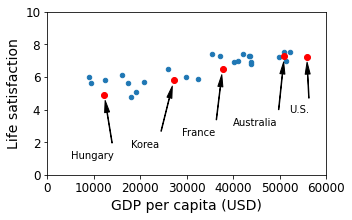

In [31]:
# 7개 국가를 제외한 국가들의 데이터 산점도
sample_data.plot(kind='scatter', x="GDP per capita", y='Life satisfaction', figsize=(5,3))
plt.axis([0, 60000, 0, 10])

# 언급된 5개 국가명 명기 좌표
position_text = {
    "Hungary": (5000, 1),
    "Korea": (18000, 1.7),
    "France": (29000, 2.4),
    "Australia": (40000, 3.0),
    "United States": (52000, 3.8),
}

# 5개 국가는 좌표를 이용하여 빨강색 점으로 표기
for country, pos_text in position_text.items():
    pos_data_x, pos_data_y = sample_data.loc[country]
    
    # 5개 국가명 표기
    country = "U.S." if country == "United States" else country
    plt.annotate(country, xy=(pos_data_x, pos_data_y), xytext=pos_text,
            arrowprops=dict(facecolor='black', width=0.5, shrink=0.1, headwidth=5))
    
    # 5개 국가 산점도 그리기
    plt.plot(pos_data_x, pos_data_y, "ro")

plt.xlabel("GDP per capita (USD)")

plt.show()

언급된 5개 국가의 1인당 GDP와 삶의 만족도를 데이터에서 직접 확인하면 다음과 같다.

In [32]:
sample_data.loc[list(position_text.keys())]

,GDP per capita,Life satisfaction
Country,,
Hungary,12239.894,4.9
Korea,27195.197,5.8
France,37675.006,6.5
Australia,50961.865,7.3
United States,55805.204,7.2


### Qeustion 1

1인당 GDP와 삶의 만족도가 어느 정도 선형 관계에 있는 것처럼 보인다.
그런데 어떤 선형 관계가 가장 적절한가 판단해야 한다. 어느 선형관계가 가장 적절한지 파악하고 그 이유를 적으시오.

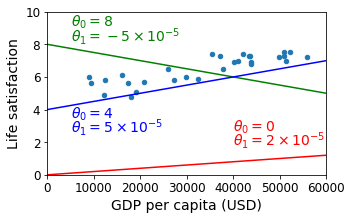

In [33]:


import numpy as np

sample_data.plot(kind='scatter', x="GDP per capita", y='Life satisfaction', figsize=(5,3))
plt.xlabel("GDP per capita (USD)")
plt.axis([0, 60000, 0, 10])

# 직서 그리기
X=np.linspace(0, 60000, 1000)

# 빨강 직선
plt.plot(X, 2*X/100000, "r")
plt.text(40000, 2.7, r"$\theta_0 = 0$", fontsize=14, color="r")
plt.text(40000, 1.8, r"$\theta_1 = 2 \times 10^{-5}$", fontsize=14, color="r")

# 초록 직선
plt.plot(X, 8 - 5*X/100000, "g")
plt.text(5000, 9.1, r"$\theta_0 = 8$", fontsize=14, color="g")
plt.text(5000, 8.2, r"$\theta_1 = -5 \times 10^{-5}$", fontsize=14, color="g")

# 파랑 직선
plt.plot(X, 4 + 5*X/100000, "b")
plt.text(5000, 3.5, r"$\theta_0 = 4$", fontsize=14, color="b")
plt.text(5000, 2.6, r"$\theta_1 = 5 \times 10^{-5}$", fontsize=14, color="b")

plt.show()


### Question 2, Question 3

#### 선형회귀 모델 + (로지스틱 회귀 모델)

위 그림에서처럼 y축의 값이 x축의 값에 선형적으로 의존하는 관계를 __선형관계__라 하며,
그런 선형관계를 함수로 구현하는 모델을 __선형회귀 모델__(linear regression model)이라 하며,
여기서는 선형회귀 모델이 1인당 GDP 하나를 인자로 사용하는 1차 함수 형식으로 구현된다.
그리고 1차 함수 모델은 직선의 절편(y축과 만나는 점)과 기울기 두 개의 값을 알면 바로 구현할 수 있다.
절편과 기울기처럼 모델 구현에 사용되는 값들을 __모델 파라미터__(model parameters)라 하며,
바로 이런 값들을 찾아내는 것이 머신러닝 모델훈련의 주요 과제이다. 

정리하면 다음과 같다. '1인당 GDP'와 '삶의 만족도' 사이의 선형관계를 최대한 잘 
반영하는 선형회귀 모델은 아래 식을 만족시키는 적절한 절편 $\theta_0$과 기울기 $\theta_1$에 의해 결정된다.

$$
\text{'삶의만족도'} = \theta_0 + \theta_1 \cdot \text{'1인당GDP'}
$$

#### 사이킷런 라이브러리 활용 선형회귀 모델 훈련 + (로지스틱 회귀 모델 훈련)

사이킷런(scikit-learn) 라이브러리는 머신러닝에서 사용되는 다양한 모델의 기본적인 틀(basic models)들을 제공한다.
선형회귀의 경우 `LinearRegression` 클래스의 객체를 생성하여 훈련시키면 
최적의 절편과 기울기를 계산해준다. 
모델을 지정하고 훈련시키는 과정은 다음과 같다.

* 과정 1: 모델 지정.

    사이킷런(sklearn) 패키지의 `linear_model` 모듈에 포함된 `LinearRegression` 클래스의 객체를 선언한다.
    선언된 모델은 아직 어떤 훈련도 하지 않은 상태이다. 

* 과정 2: 모델 지정.

    사이킷런(sklearn) 패키지의 `linear_model` 모듈에 포함된 `LogisticRegression` 클래스의 객체를 선언한다.
    선언된 모델은 아직 어떤 훈련도 하지 않은 상태이다. 

In [55]:
from sklearn import linear_model

#lin1 = linear_model.LinearRegression()

## Check
lin1 = linear_model.Ridge()

* 과정 2: 훈련 세트 지정. 입력 데이터와 타깃 데이터를 2차원 어레이로 지정한다. 
    이유는 선형회귀 모델이 2차원 어레이 형식의 입력 데이터를 요구하기 때문이다.
    * 입력 데이터: x축에 해당하는 값이며 여기서는 1인당 GDP 사용.
    * 타깃 데이터: y축에 해당하는 값이며 여기서는 삶의 만족도 사용.

In [56]:
Xsample = np.c_[sample_data["GDP per capita"]]
ysample = np.c_[sample_data["Life satisfaction"]]

입력 데이터 훈련 세트에 포함된 모든 데이터 샘플을 항목으로 갖는다.
여기서는 각 샘플 데이터가 1인당 GDP에 해당하는 한 개의 값으로 이루어져 있기에 길이가 일인 1차원 어레이로 표현된다.
일반적으로는 하나의 훈련 샘플 데이터는 다양한 특성을 가진, 즉, 길이가 1보다 큰 1차원 어레이로 표현된다.
따라서 모든 입력 데이터를 아래와 같은 $m$x$n$ 모양의 2차원 어레이로 표현할 수 있다. 

- $m$: 훈련 세트 크기, 즉 훈련 데이터 샘플의 개수. 여기서는 30개 OECD 국가 데이터를 사용하므로 $m = 30$.
- $n$: 훈련 데이터 샘플의 특성 수. 여기서는 국가별 특성으로 1인당 GDP만 사용하므로 $n=1$. 
- $\mathbf{x}_{j}^{(i)}$: $i$ 번째 훈련 입력 데이터 샘플의 $j$번째 특성값.

$$
\mathbf{X}_{\textit{train}} = 
\begin{bmatrix}
\mathbf{x}_{1}^{(1)} & \mathbf{x}_{2}^{(1)} & \cdots & \mathbf{x}_{n}^{(1)}\\
\mathbf{x}_{1}^{(2)} & \mathbf{x}_{2}^{(2)} & \cdots & \mathbf{x}_{n}^{(2)}\\
 & \vdots & \\
\mathbf{x}_{1}^{(m)} & \mathbf{x}_{2}^{(m)} & \cdots & \mathbf{x}_{n}^{(m)}
\end{bmatrix}
$$

처음 5개의 입력 데이터는 다음과 같다.

In [57]:
Xsample[:5]

array([[ 9054.914],
       [ 9437.372],
       [12239.894],
       [12495.334],
       [15991.736]])

타깃값 또한 여러 개의 값으로 이루어져 있는 경우가 있기 때문에 각 훈련 데이터 샘플에 대한 타깃도 1차원 어레이로 표현된다.
따라서 타깃 데이터 세트 역시 2차원 어레이로 다뤄진다.

처음 5개의 입력 데이터 샘플에 대한 타깃은 다음과 같다.

In [58]:
ysample[:5]

array([[6. ],
       [5.6],
       [4.9],
       [5.8],
       [6.1]])

* 과정 3: 모델 훈련. 최적의 $\theta_0$와 $\theta_1$를 찾아가는 과정.
    `LinearRegression` 모델의 경우 `fit()` 메서드를 지정된 훈련 세트와 함께 호출하면 됨.
    `fit()` 메서의 반환값은 훈련된 `LinearRegression` 객체다.    

In [59]:
lin1.fit(Xsample, ysample)


Ridge()

훈련된 모델이 알아낸 최적 선형 모델의 절편과 기울기는 아래 두 속성에 저장된다.

* `intercept_[0]`: 직선의 절편
* `coef_[0]`: 직선의 기울기

In [60]:
t0, t1 = lin1.intercept_[0], lin1.coef_[0][0]

print(f"절편:\t {t0}t1")
print(f"기울기:\t {t1}t1")

절편:	 4.853052800539347t1
기울기:	 4.9115445883411844e-05t1


구해진 기울기와 절편을 이용하여 산점도와 함께 직선을 그리면 다음과 같다.

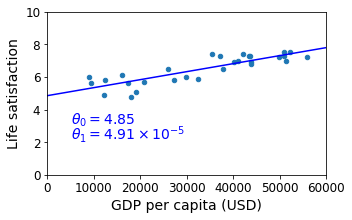

In [61]:
# 산점도
sample_data.plot(kind='scatter', x="GDP per capita", y='Life satisfaction', figsize=(5,3))
plt.xlabel("GDP per capita (USD)")
plt.axis([0, 60000, 0, 10])

# 직선 그리기
X=np.linspace(0, 60000, 1000)
plt.plot(X, t0 + t1*X, "b")
# 직선의 절편과 기울기 정보 명시
plt.text(5000, 3.1, r"$\theta_0 = 4.85$", fontsize=14, color="b")
plt.text(5000, 2.2, r"$\theta_1 = 4.91 \times 10^{-5}$", fontsize=14, color="b")

plt.show()

### 5단계: 학습된 모델 활용

훈련된 모델을 이용하여 한 국가의 삶의 만족도를 1인당 GDP를 이용하여 예측한다. 
예를 들어, OECD 비회원국인 키프러스(Cyprus)의 1인당 GDP가 다음과 같이 알려져 있을 때 
키프러스 국민의 삶의 만족도를 예측한다.

* 키프러스 1인당 GDP: 22587

In [62]:
cyprus_gdp_per_capita = gdp_per_capita.loc["Cyprus"]["GDP per capita"]

cyprus_gdp_per_capita

22587.49

훈련된 모델의 `predict()` 메서드를 이용하면 키프러스 국민의 삶의 만족도는 5.96 정도로 예측된다.

In [63]:
cyprus_predicted_life_satisfaction = lin1.predict([[cyprus_gdp_per_capita]])[0, 0]

cyprus_predicted_life_satisfaction

5.962447443276453

아래 도표에서 확인할 수 있듯이 예측값은 정확하게 앞서 확인한 최적의 직선 위에 위치한다.

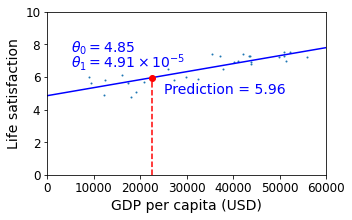

In [64]:
sample_data.plot(kind='scatter', x="GDP per capita", y='Life satisfaction', figsize=(5,3), s=1)
plt.xlabel("GDP per capita (USD)")

# 예측된 최적의 직선
X=np.linspace(0, 60000, 1000)
plt.plot(X, t0 + t1*X, "b")
plt.axis([0, 60000, 0, 10])
plt.text(5000, 7.5, r"$\theta_0 = 4.85$", fontsize=14, color="b")
plt.text(5000, 6.6, r"$\theta_1 = 4.91 \times 10^{-5}$", fontsize=14, color="b")

# 키프러스에 대한 삶의 만족도 예측값

# 빨간 점선 그리기
plt.plot([cyprus_gdp_per_capita, cyprus_gdp_per_capita], [0, cyprus_predicted_life_satisfaction], "r--")
plt.text(25000, 5.0, r"Prediction = 5.96", fontsize=14, color="b")

# 예측 지점 좌표 찍기(빨강생)
plt.plot(cyprus_gdp_per_capita, cyprus_predicted_life_satisfaction, "ro")

plt.show()

## 머신러닝의 주요 도전 과제

머신러닝 알고리즘을 훈련시키다보면 다음과 같은 도전 과제에 부딛친다. 

- 대표성 없는 훈련 데이터
- 과대적합과 모델 규제

### 대표성 없는 훈련 데이터

앞서 7개 국가의 데이터를 훈련에서 제외시킨 후에 선형회귀 모델을 훈련시켰다.
이제 7개 국가를 포함해서 훈련시켜 보자.
제외된 7개 국가의 데이터는 다음과 같다.

* 브라질(Brazil)
* 멕시코(Mexico)
* 칠레(Chile)
* 체코(Czech Repulic)
* 노르웨이(Norway)
* 스위스(Switzerland)
* 룩셈부르크(Luxembourg)

In [65]:
missing_data

,GDP per capita,Life satisfaction
Country,,
Brazil,8669.998,7.0
Mexico,9009.280,6.7
Chile,13340.905,6.7
Czech Republic,17256.918,6.5
Norway,74822.106,7.4
Switzerland,80675.308,7.5
Luxembourg,101994.093,6.9


아래 좌표는 7개 국가명을 아래 도표에서 표기할 때 사용할 좌표이다.

In [66]:
position_text2 = {
    "Brazil": (1000, 9.0),
    "Mexico": (11000, 9.0),
    "Chile": (25000, 9.0),
    "Czech Republic": (35000, 9.0),
    "Norway": (60000, 3),
    "Switzerland": (72000, 3.0),
    "Luxembourg": (90000, 3.0),
}

7개 국가를 포함한 전체 훈련 데이터셋을 이용하여 훈련한 결과를
7개 국가를 제외했을 때의 훈련 결과와 비교한다.

* 검정 실선: 7개 국가 포함 예측 선형 모델
* 파랑 점선: 7개 국가 제외 예측 선형 모델

__결론:__ 선형회귀 모델은 1인당 GDP와 삶의 만족도 사이의 관계를 모델링 하기에 부적합하다.

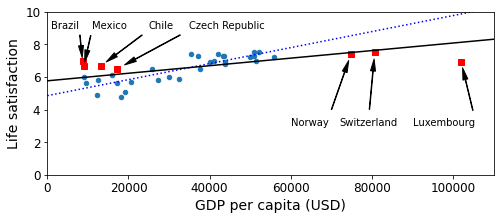

In [67]:
# 7개 국가를 제외한 국가들의 산점도 (파랑색 점)
sample_data.plot(kind='scatter', x="GDP per capita", y='Life satisfaction', figsize=(8,3))
plt.axis([0, 110000, 0, 10])

# 7개 국가 산점도(빨강 점)
for country, pos_text in position_text2.items():
    pos_data_x, pos_data_y = missing_data.loc[country]
    # 7개 국가명 표기
    plt.annotate(country, xy=(pos_data_x, pos_data_y), xytext=pos_text,
            arrowprops=dict(facecolor='black', width=0.5, shrink=0.1, headwidth=5))
    plt.plot(pos_data_x, pos_data_y, "rs")

# 7개 국가 제외 예측 선형 모델 그래프 (파랑 점선)
X=np.linspace(0, 110000, 1000)
plt.plot(X, t0 + t1*X, "b:")

# 7개 국가 포함 선형회귀 모델 훈련 및 예측
lin_reg_full = linear_model.LinearRegression()
Xfull = np.c_[oecd_country_stats["GDP per capita"]]
yfull = np.c_[oecd_country_stats["Life satisfaction"]]
lin_reg_full.fit(Xfull, yfull)

# 7개 국가 포함 예측 선형 모델 그래프(검정 실선)
t0full, t1full = lin_reg_full.intercept_[0], lin_reg_full.coef_[0][0]
X = np.linspace(0, 110000, 1000)
plt.plot(X, t0full + t1full * X, "k")
plt.xlabel("GDP per capita (USD)")

plt.show()

### 과대적합과 모델 규제

#### 과대적합 (개선)

훈련된 모델이 훈련데이터에는 너무나도 잘 맞지만 새로운 데이터에 대해서는 잘 작동하지 않을 때 해당 모델이 훈련데이터에 __과대적합__되었다고 말한다.

예를 들어, 
아래 코드는 4장에서 다룰 고차항 다항회귀를 이용하여 선형이 아니라 60차 다항식의 그래프로 모델을 예측한다.
결과는 훈련데이터셋에 매우 잘 들어맞지만, 새루운 데이터에 대해 훈련된 모델이 제대로된 예측을 할 수 있을 
거라고 믿기는 어렵다. 이런 모델은 __일반화가 어렵다__라고 말한다.

__주의사항:__ 아래 코드를 지금 당장 이해하려고 시도할 필요는 없다.

Saving figure overfitting_model_plot


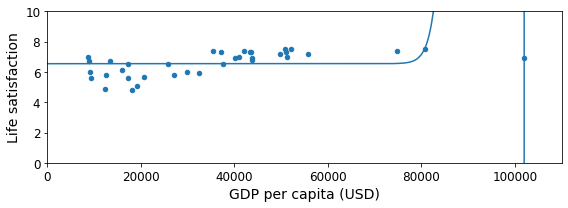

In [68]:
oecd_country_stats.plot(kind='scatter', x="GDP per capita", y='Life satisfaction', figsize=(8,3))
plt.axis([0, 110000, 0, 10])  

from sklearn import preprocessing
from sklearn import pipeline

poly = preprocessing.PolynomialFeatures(degree=60, include_bias=False)
#scaler = preprocessing.StandardScaler()  ('scal', scaler),
lin_reg2 = linear_model.LinearRegression()

pipeline_reg = pipeline.Pipeline([('poly', poly), ('lin', lin_reg2)])
pipeline_reg.fit(Xfull, yfull)
curve = pipeline_reg.predict(X[:, np.newaxis])
plt.plot(X, curve)
plt.xlabel("GDP per capita (USD)")
save_fig('overfitting_model_plot')
plt.show()

훈련세트에 잡음이 많이 있거나 데이터셋이 너무 작으면 훈련 과정에서 별로 상관 없는 특성을 이용하려고 시도할 수도 있다. 
예를 들어, 아래 코드에서 확인할 수 있듯이 OECD에 속하는 국가 중에서 나라 이름에 영어 알파벳 W가 포함된 아래의 나라의 삶의 만족도가 매우 높은 편이다. 

In [69]:
oecd_country_stats.loc[[c for c in oecd_country_stats.index if "W" in c.upper()]]["Life satisfaction"]

Country
New Zealand    7.3
Sweden         7.2
Norway         7.4
Switzerland    7.5
Name: Life satisfaction, dtype: float64

하지만 그렇다해서 나라명에 영어 알파벳 W가 포함된 모든 나라의 삶의 만족도가 높다고 결론 지을 수는 없다.
실제로 영어 알파벳 W를 포함한 국가 중에 여러 국가의 1인당 GDP가 아래 코드에서 볼 수 있듯이 매우 낮은데,
예를 들어, 루완다(Rwanda), 짐바브웨(Zimbabwe) 등의 국가의 삶의 만족도를 그럼에도 불구하고 매우 높다고 말할 수는 없다.

In [70]:
gdp_per_capita.loc[[c for c in gdp_per_capita.index if "W" in c.upper()]].head()

,Subject Descriptor,Units,Scale,Country/Series-specific Notes,GDP per capita,Estimates Start After
Country,,,,,,
Botswana,"Gross domestic product per capita, current prices",U.S. dollars,Units,"See notes for: Gross domestic product, curren...",6040.957,2008.0
Kuwait,"Gross domestic product per capita, current prices",U.S. dollars,Units,"See notes for: Gross domestic product, curren...",29363.027,2014.0
Malawi,"Gross domestic product per capita, current prices",U.S. dollars,Units,"See notes for: Gross domestic product, curren...",354.275,2011.0
New Zealand,"Gross domestic product per capita, current prices",U.S. dollars,Units,"See notes for: Gross domestic product, curren...",37044.891,2015.0
Norway,"Gross domestic product per capita, current prices",U.S. dollars,Units,"See notes for: Gross domestic product, curren...",74822.106,2015.0


#### 모델 규제

4장에서 다루는 '규제가 있는 선형 모델'에서 다루는 이용하면 과대적합의 위험을 줄일 수 있다.
이렇게 과대적합의 위험을 감소시키기 위에 훈련 모델에 제약을 가하는 것을 __규제__(regularization)라고 한다.

아래 코드는 세 개의 모델을 비교한다.

* 빨강 파선: 7개 국가 포함 예측 선형 모델
* 파랑 점선: 7개 국가 제외 예측 선형 모델
* 파랑 실선: 7개 국가 제외 규제 적용 예측 선형 모델
    * 규제 방식: Ridge 규제(4장 참조)

7개 국가를 제외하더라도 모델에 규제를 적용하면 데이터에 덜 과대적합한 모델을 얻게 됨을 
세 개의 그래프를 비교해서 알 수 있다.

Saving figure ridge_model_plot


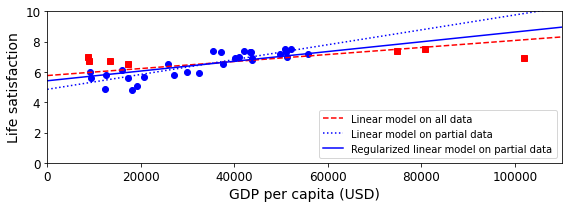

In [71]:
plt.figure(figsize=(8,3))

plt.xlabel("GDP per capita")
plt.ylabel('Life satisfaction')

# 7개 국가 제외 데이터 산점도(파랑 동그라미)
plt.plot(list(sample_data["GDP per capita"]), list(sample_data["Life satisfaction"]), "bo")
# 제외된 7개 국가 산점도(빨강 네모)
plt.plot(list(missing_data["GDP per capita"]), list(missing_data["Life satisfaction"]), "rs")

# 7개 국가 포함 예측 선형 모델 그래프(빨강 파선)
X = np.linspace(0, 110000, 1000)
plt.plot(X, t0full + t1full * X, "r--", label="Linear model on all data")
# 7개 국가 제외 예측 선형 모델 그래프(파랑 점선)
plt.plot(X, t0 + t1*X, "b:", label="Linear model on partial data")

# 릿지(Ridge) 규제 적용 훈련: 7개 국가 제외 데이터 대상
ridge = linear_model.Ridge(alpha=10**9.5)
Xsample = np.c_[sample_data["GDP per capita"]]
ysample = np.c_[sample_data["Life satisfaction"]]
ridge.fit(Xsample, ysample)
# 릿지 규제 적용 예측 선형 모델 그래프(파랑 실선)
t0ridge, t1ridge = ridge.intercept_[0], ridge.coef_[0][0]
plt.plot(X, t0ridge + t1ridge * X, "b", label="Regularized linear model on partial data")

plt.legend(loc="lower right")
plt.axis([0, 110000, 0, 10])
plt.xlabel("GDP per capita (USD)")
save_fig('ridge_model_plot')
plt.show()

## 사례 기반 학습

키프러스의 삶의 만족도를 사례 기반 학습으로 예측하기 위해
1인당 GDP가 키프러스의 경우가 가장 가까운 국가들의 삶의 만족도의 평균값을 활용할 수 있다.

예를 들어, 키프러스의 1인당 GDP와 가장 가까운 세 나라는 다음과 같다.

* 포루투갈(Portugal)
* 슬로베니아(Slovenia)
* 스페인(Spain)

In [72]:
sample_data[7:10]

,GDP per capita,Life satisfaction
Country,,
Portugal,19121.592,5.1
Slovenia,20732.482,5.7
Spain,25864.721,6.5


위 세 나라의 삶의 만족도의 평균값은 다음과 같다.

In [73]:
(5.1 + 5.7 + 6.5)/3

5.766666666666667

앞서 설명한 알고리즘을 __k-최근접 이웃__ 회귀라고 하며,
위 예제에서 사용된 k는 3이다. 

사이킷런에서 지원하는 k-최근접 이웃 회귀모델을 적용하면 동일한 결과를 얻게 된다.

* `n_neighbors = 3`: 예측할 데이터와 가장 가까운 3개의 훈련 데이터 정보를 활용한다는 의미임.

In [74]:
import sklearn.neighbors
model = sklearn.neighbors.KNeighborsRegressor(n_neighbors=3)

In [75]:
X = np.c_[sample_data["GDP per capita"]]
y = np.c_[sample_data["Life satisfaction"]]

# 모델 훈련
model.fit(X, y)

# 키프러스 국가에 대한 예측하기
X_new = np.array([[22587.0]])  # Cyprus' GDP per capita
print(model.predict(X_new)) # outputs [[ 5.76666667]]

[[5.76666667]]


## 과제 (개선)

1. OECD 삶의 만족도 데이터와 IMF 1인당 GDP 데이터를 2020년 기준으로 업데이트하여 앞서 살펴본 과정과 동일한 과정을 수행하라.
    2020년 기준 데이터는 아래 정보를 사용한다.
    
    * 기본 다운로드 경로
    
    ```python
    DOWNLOAD_ROOT = "https://github.com/codingalzi/handson-ml2/tree/master/notebooks/datasets/lifesat"
    ```
    
    * BLI 데이터 파일명: oecd_bli_2020.csv
    * 1인당 GDP 데이터: gdp_per_capita_2020.xlsx
    
    주의사항:

    * 1인당 GDP 데이터는 엑셀 파일로 주어졌다. 팬다스의 `read_csv()` 대신에 `read_excel()` 파일을 사용한다.
    * `rename()` 메서드를 활용할 때 '2020' 문자열 대신에 2020 정수를 사용해야 한다.
    * 제외되는 7개 국가 정보는 다음과 같다.
        * 제외 국가 인덱스

        ```python
        remove_indices = [1, 2, 4, 6, 37, 38, 39]
        keep_indices = list(set(range(40)) - set(remove_indices))
        ```
        
        * 제외 국가: Columbia(콜롬비아), Brazil(브라질), Mexico(멕시코), Chille(칠레), 
            Ireland(아일랜드), Switzerland(스위스, Luxembourg(룩셈부르크)
        
    * 언급된 5개 국가명 명기 좌표

    ```python
    position_text = {
        "Hungary": (8000, 1),
        "Korea": (26000, 1.7),
        "France": (34000, 2.4),
        "Australia": (44000, 3.0),
        "United States": (60000, 3.8),
    }
    ```